In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv('Data/project_adult.csv', encoding='utf-8')

In [3]:
# process and standardize data
# This is not an all inclusive function....you should improve!
def preprocess_data(df):

    # Handle missing values by replacing '?' with NaN and dropping rows
    for col in df.columns:
        df[col] = df[col].replace('?', pd.NA)


    df = df.dropna()

    # Drop unnamed column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)

    # split off target early (if present)
    y = None
    if 'income' in df.columns:
        y = df['income']
        df = df.drop(columns=['income'])
    
    if y is not None:
        le = LabelEncoder()
        y = le.fit_transform(y).astype(int)  # encode target as int

    # detect numeric vs categorical by attempted coercion
    numeric_cols, categorical_cols = [], []
    for col in df.columns:
        coerced = pd.to_numeric(df[col], errors='coerce')
        if coerced.notna().all():
            df[col] = coerced.astype(float)   # numeric as float
            numeric_cols.append(col)
        else:
            df[col] = df[col].astype(str)     # categorical as string
            categorical_cols.append(col)
    
    # label-encode categoricals only
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col]).astype(int)  # encoded as int
        label_encoders[col] = le

    # standardize numeric columns only
    scaler = StandardScaler()
    if numeric_cols:
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols].astype(float)).astype(float)

    # Encode categorical features
    label_encoders = {}
    for col in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le


    # Make X and y arrays
    X = df.values.astype(float)
    if y is not None:
        y = y.astype(int)

    return X, y

In [4]:
class Perceptron:
    """Perceptron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.

    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    errors_ : list
      Number of misclassifications (updates) in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        # if you use libarry versions stated by book use float_, else if new use float64
        # self.b_ = np.float_(0.)
        self.b_ = np.float64(0.)
        
        self.errors_ = []

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                update = self.eta * (target - self.predict(xi))
                self.w_ += update * xi
                self.b_ += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)

In [5]:
class AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)          
            self.w_ += self.eta * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)

            # Simple safety: if loss becomes NaN or explodes, shrink LR and continue
            if not np.isfinite(loss) or (len(self.losses_) > 1 and loss > 10 * self.losses_[-2]):
                self.eta *= 0.5
          
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [6]:
class AdalineSGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    shuffle : bool (default: True)
      Shuffles training data every epoch if True to prevent cycles.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
        Bias unit after fitting.
    losses_ : list
      Mean squared error loss function value averaged over all
      training examples in each epoch.

        
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.losses_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            losses = []
            for xi, target in zip(X, y):
                losses.append(self._update_weights(xi, target))
            avg_loss = np.mean(losses)
            self.losses_.append(avg_loss)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Initialize weights to small random numbers"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=m)
        self.b_ = np.float64(0.)
        self.w_initialized = True
        
    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_ += self.eta * 2.0 * xi * (error)
        self.b_ += self.eta * 2.0 * error
        loss = error**2
        return loss
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

In [7]:
X, y = preprocess_data(df)

X.shape, y.shape

((24157, 14), (24157,))

## Perceptron

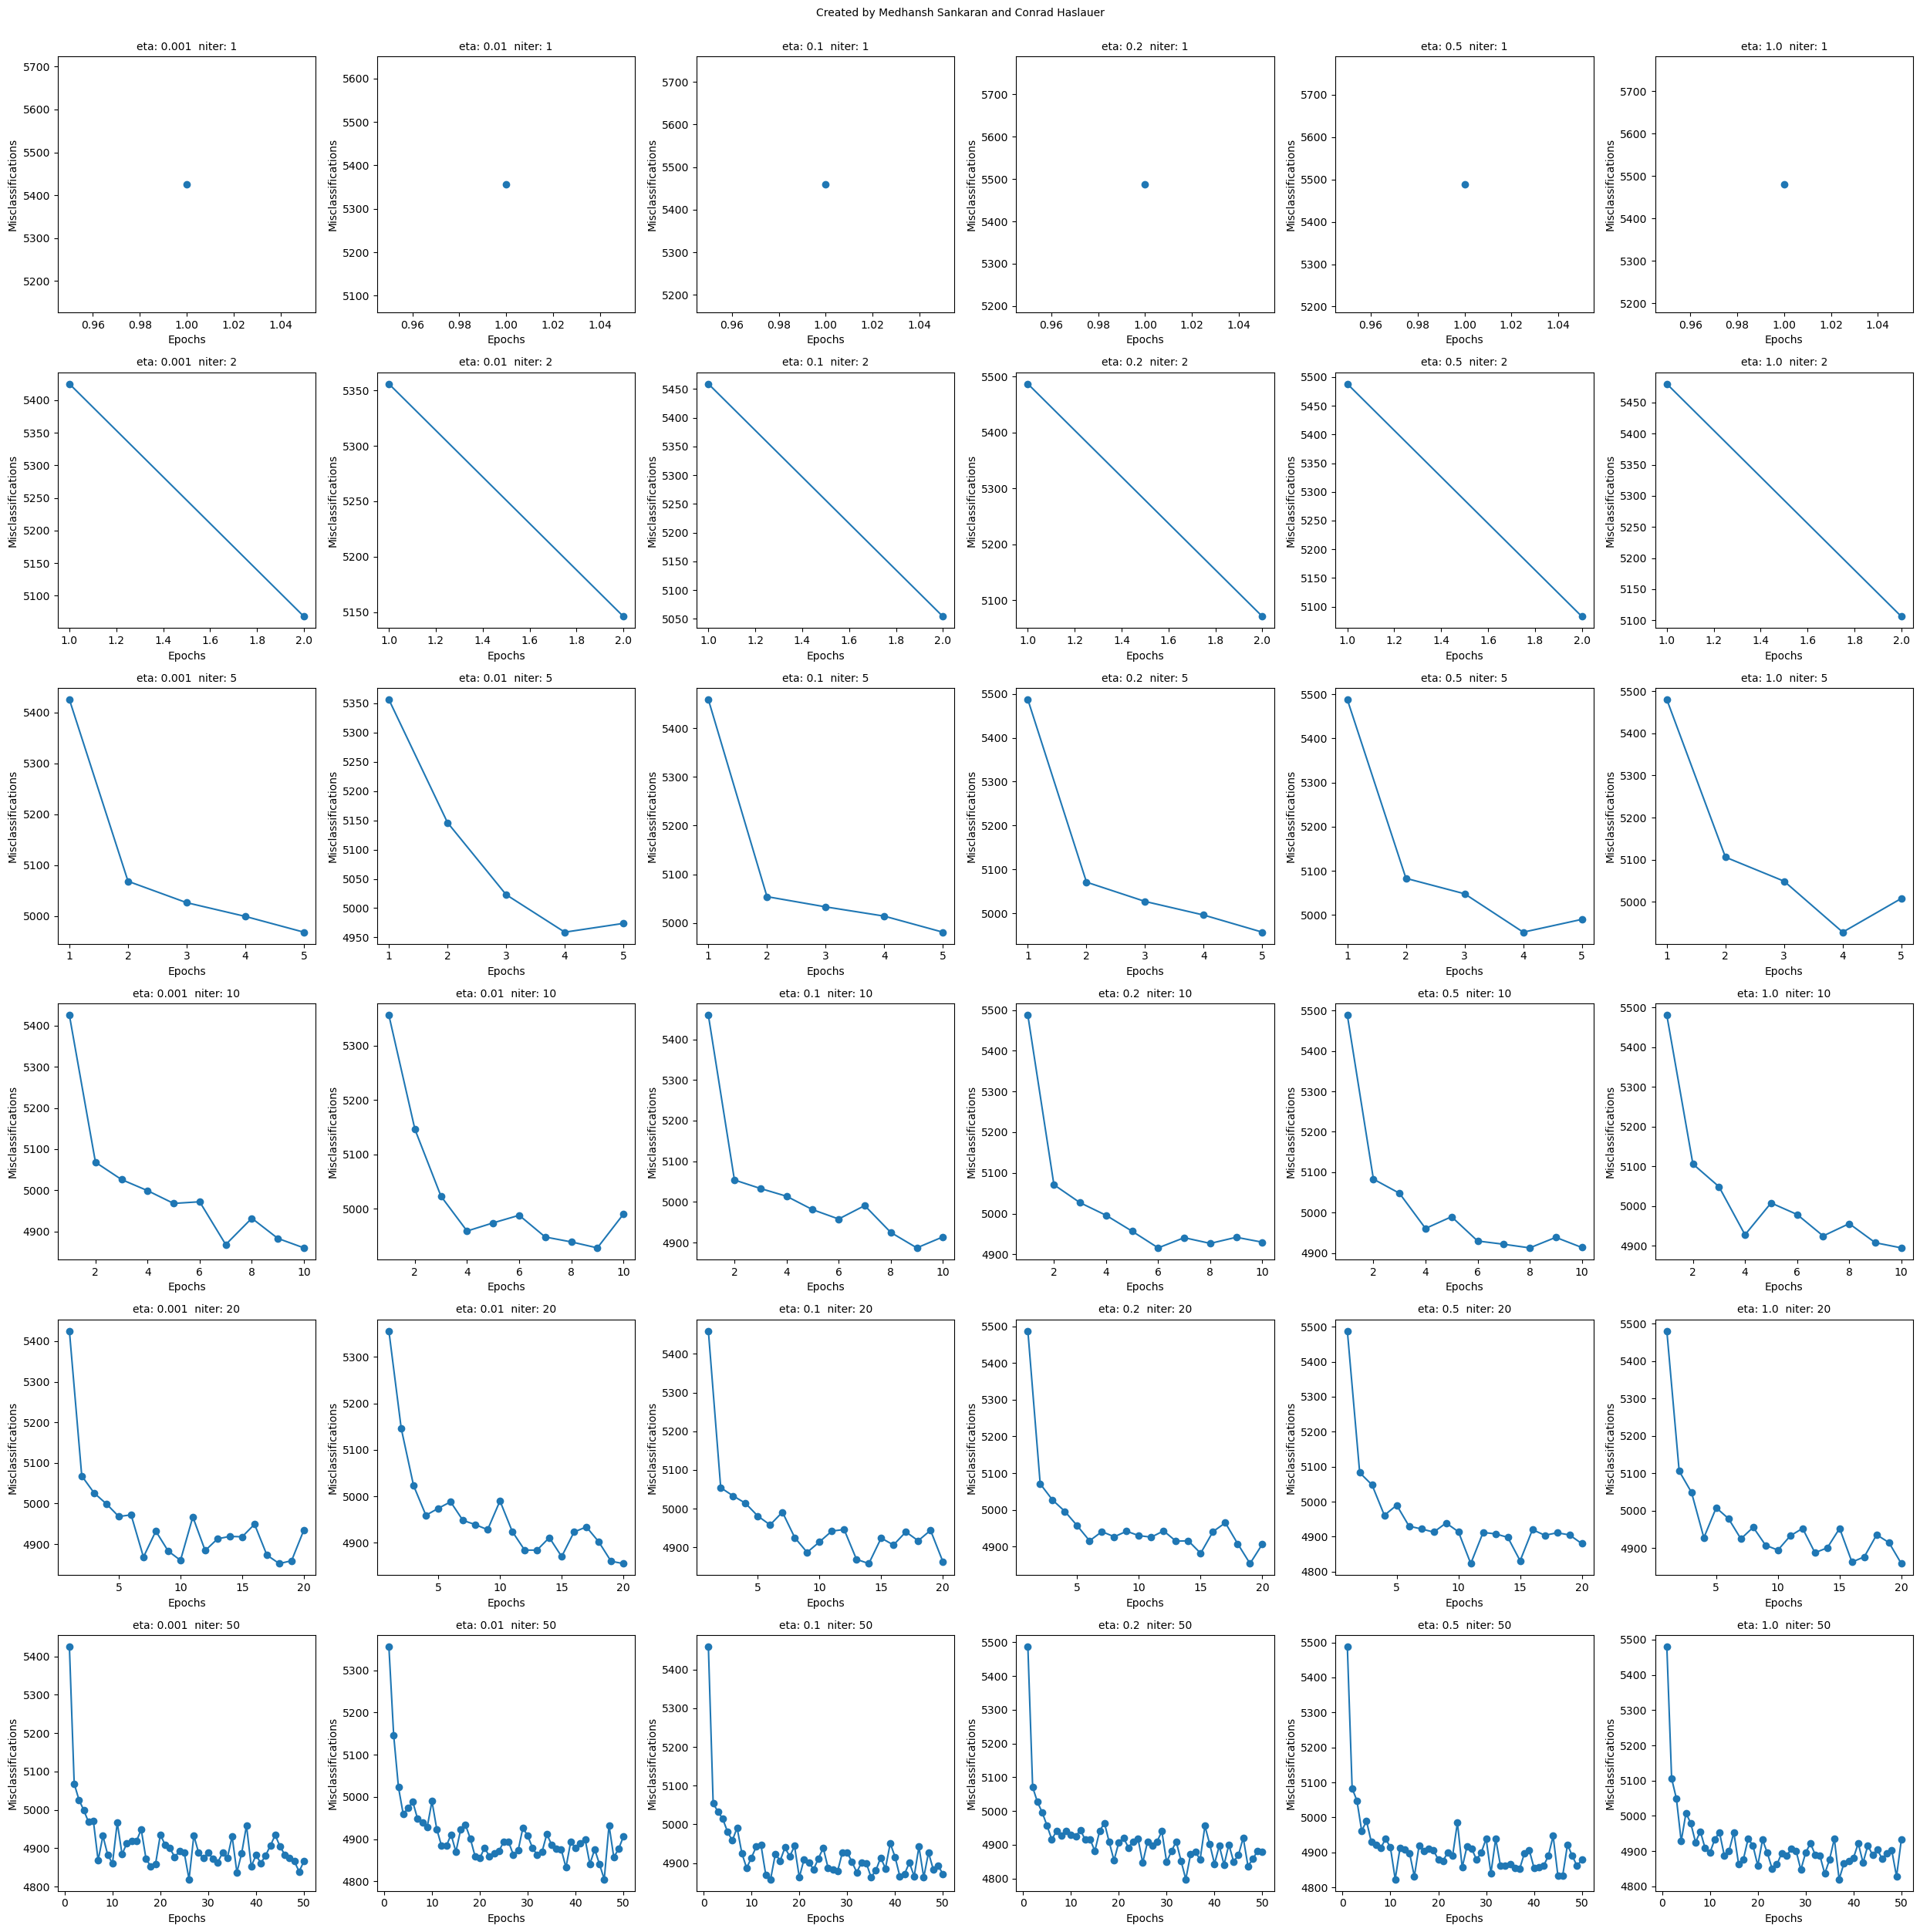

In [8]:
# Train Perceptron and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(25, 25))

list_eta = [1e-3, 0.01, 0.1, 0.2, 0.5, 1.0]
list_niter = [1, 2, 5, 10, 20, 50]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

fig.suptitle("Created by Medhansh Sankaran and Conrad Haslauer", fontsize=10, y=1)

best_acc = -1.0
best_model = None
best_params = (None, None)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ppn = Perceptron(eta=e_temp, n_iter=n_temp).fit(X_train, y_train)

        y_pred = ppn.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        ax[j, i].plot(range(1, len(ppn.errors_) + 1), ppn.errors_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('Misclassifications', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        # Track best
        if acc > best_acc:
            best_acc = acc
            best_params = (e_temp, n_temp)
            best_model = ppn
    
plt.tight_layout()
plt.show()

In [9]:
# Best model results
print(f"Best Perceptron Model - eta: {best_params[0]}, n_iter: {best_params[1]}, Accuracy: {best_acc:.4f}")

Best Perceptron Model - eta: 1.0, n_iter: 10, Accuracy: 0.8195


## Adaline

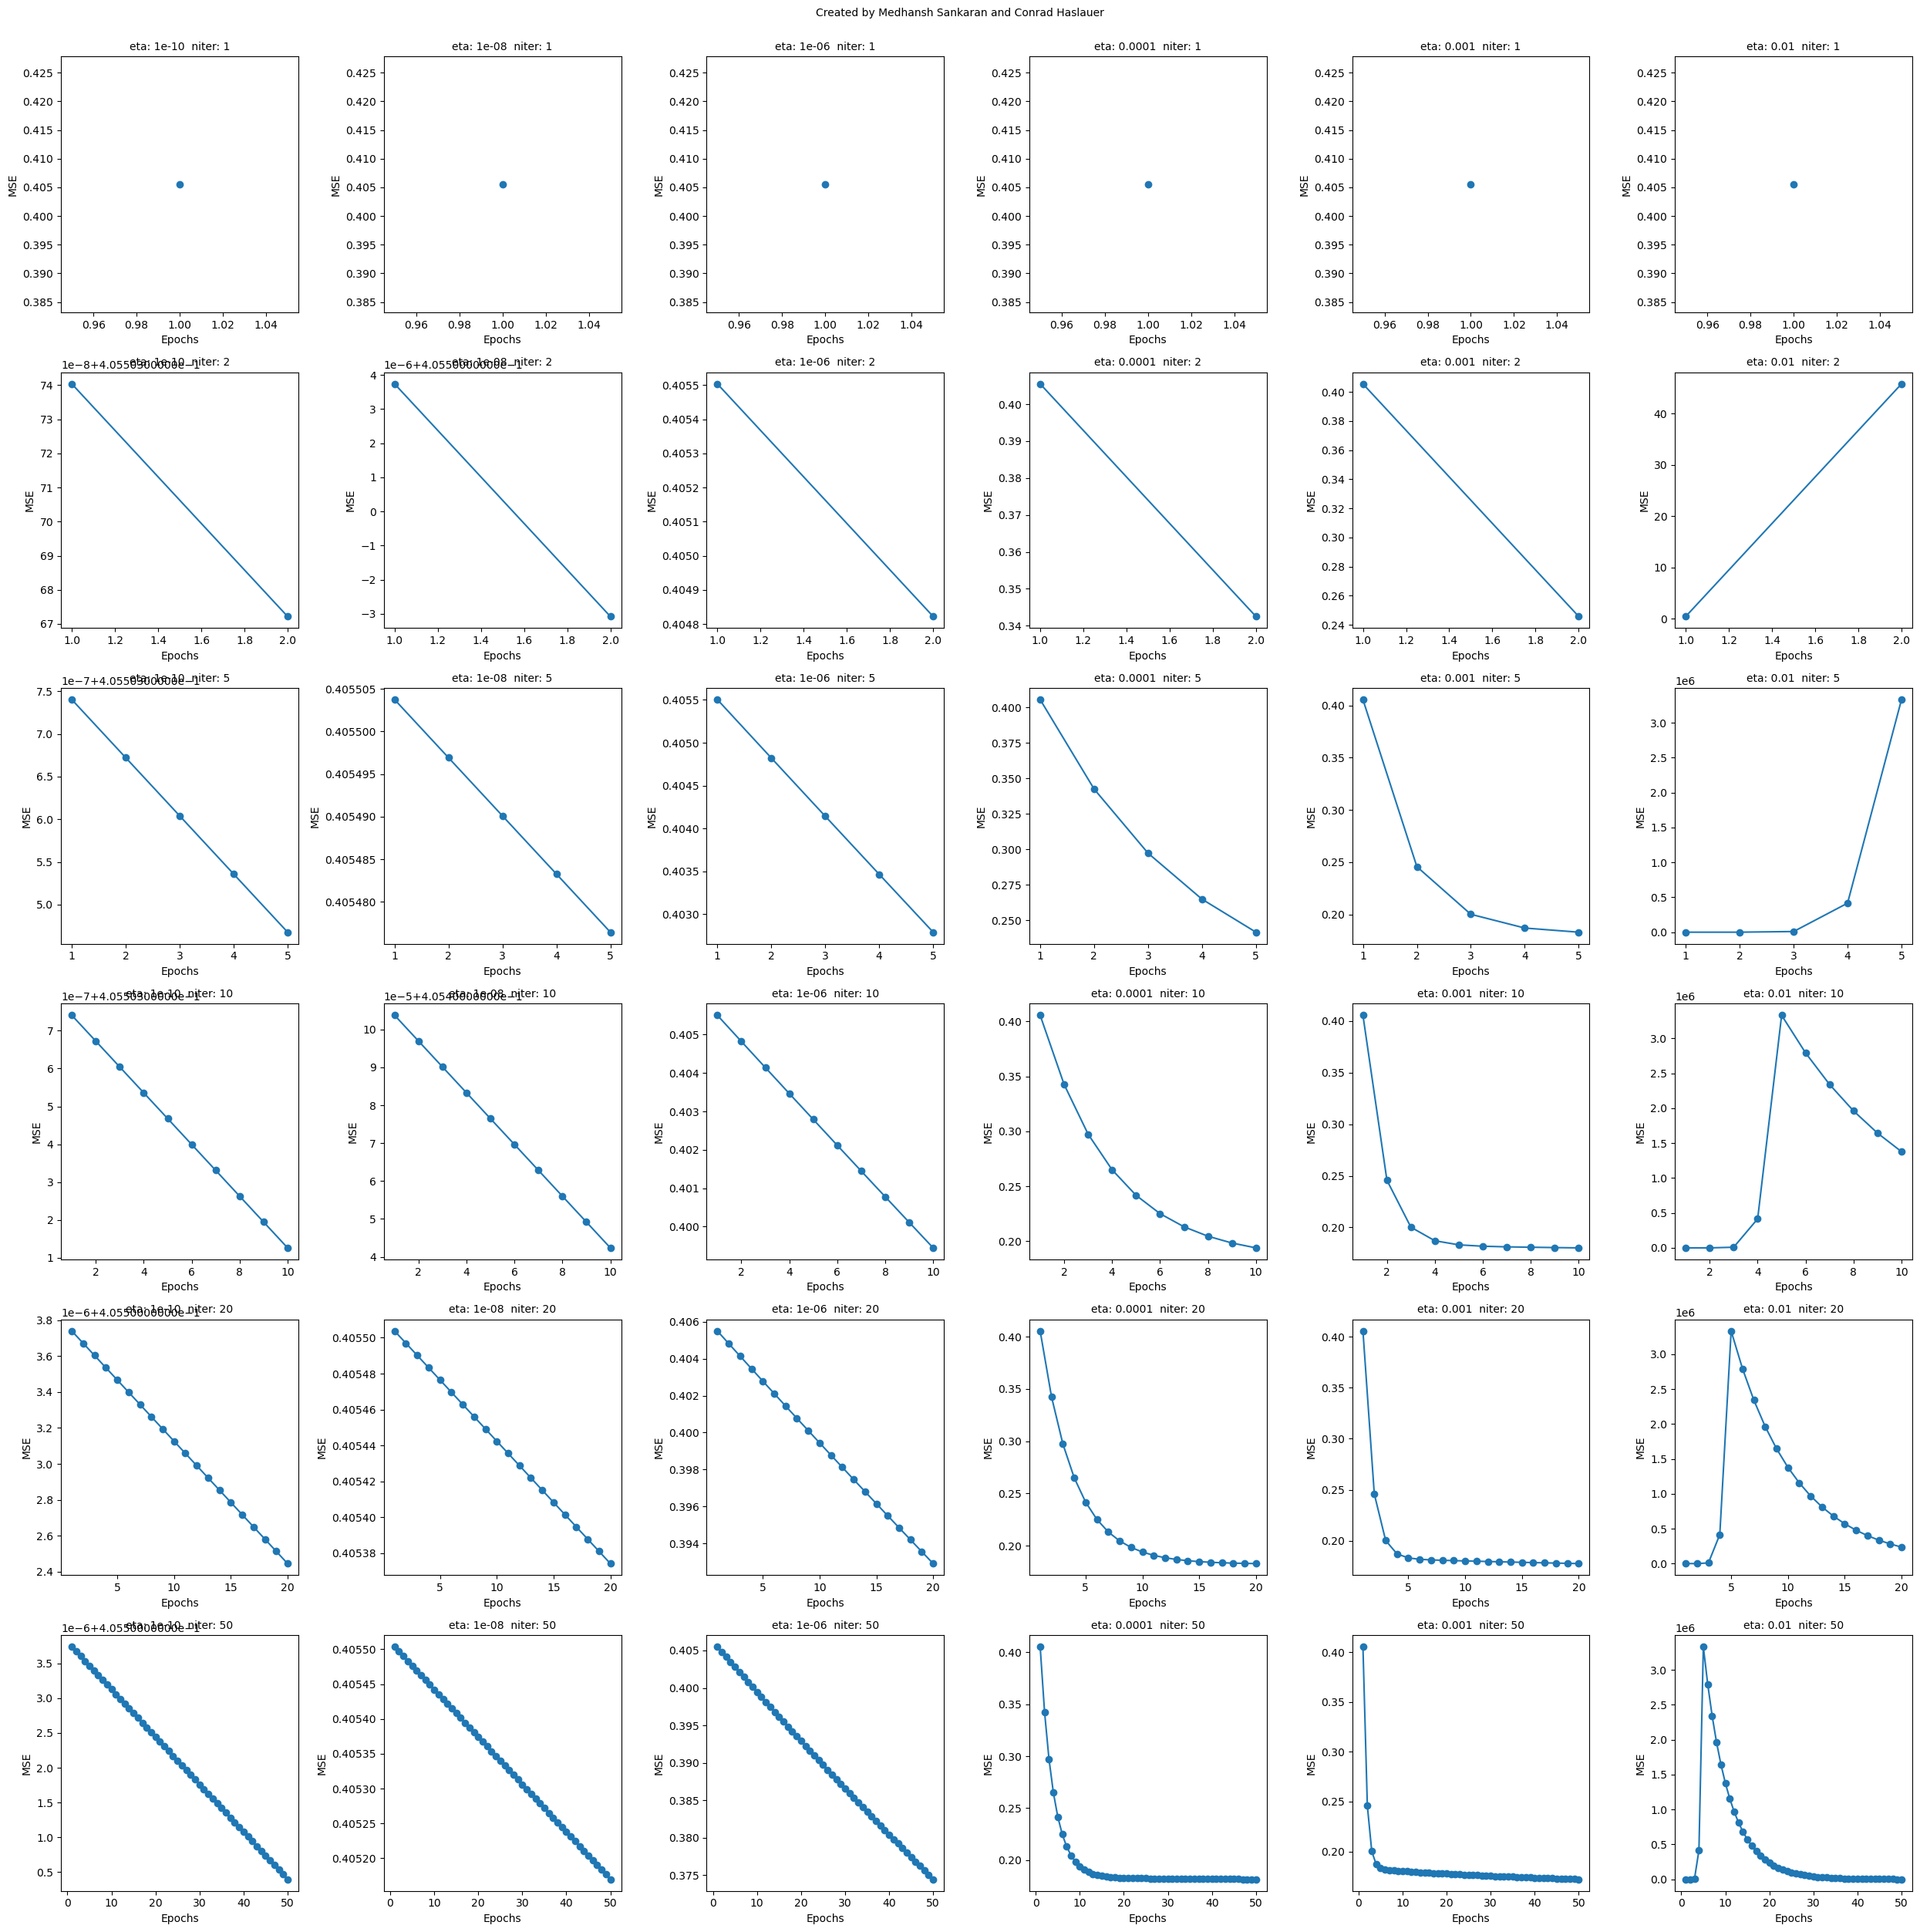

In [10]:
# Train Adaline and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(25, 25))

list_eta = [1e-10, 1e-8, 1e-6, 1e-4, 1e-3, 1e-2]
list_niter = [1, 2, 5, 10, 20, 50]

fig.suptitle("Created by Medhansh Sankaran and Conrad Haslauer", fontsize=10, y=1)

best_ada_acc = -1.0
best_ada_model = None
best_ada_params = (None, None)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineGD(eta=e_temp, n_iter=n_temp).fit(X_train, y_train)

        y_pred = ada.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('MSE', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        if acc > best_ada_acc:
            best_ada_acc = acc
            best_ada_params = (e_temp, n_temp)
            best_ada_model = ada
    
plt.tight_layout()
plt.show()

In [11]:
# Best adaline model results
print(f"Best Adaline Model - eta: {best_ada_params[0]}, n_iter: {best_ada_params[1]}, Accuracy: {best_ada_acc:.4f}")

Best Adaline Model - eta: 0.001, n_iter: 50, Accuracy: 0.7630


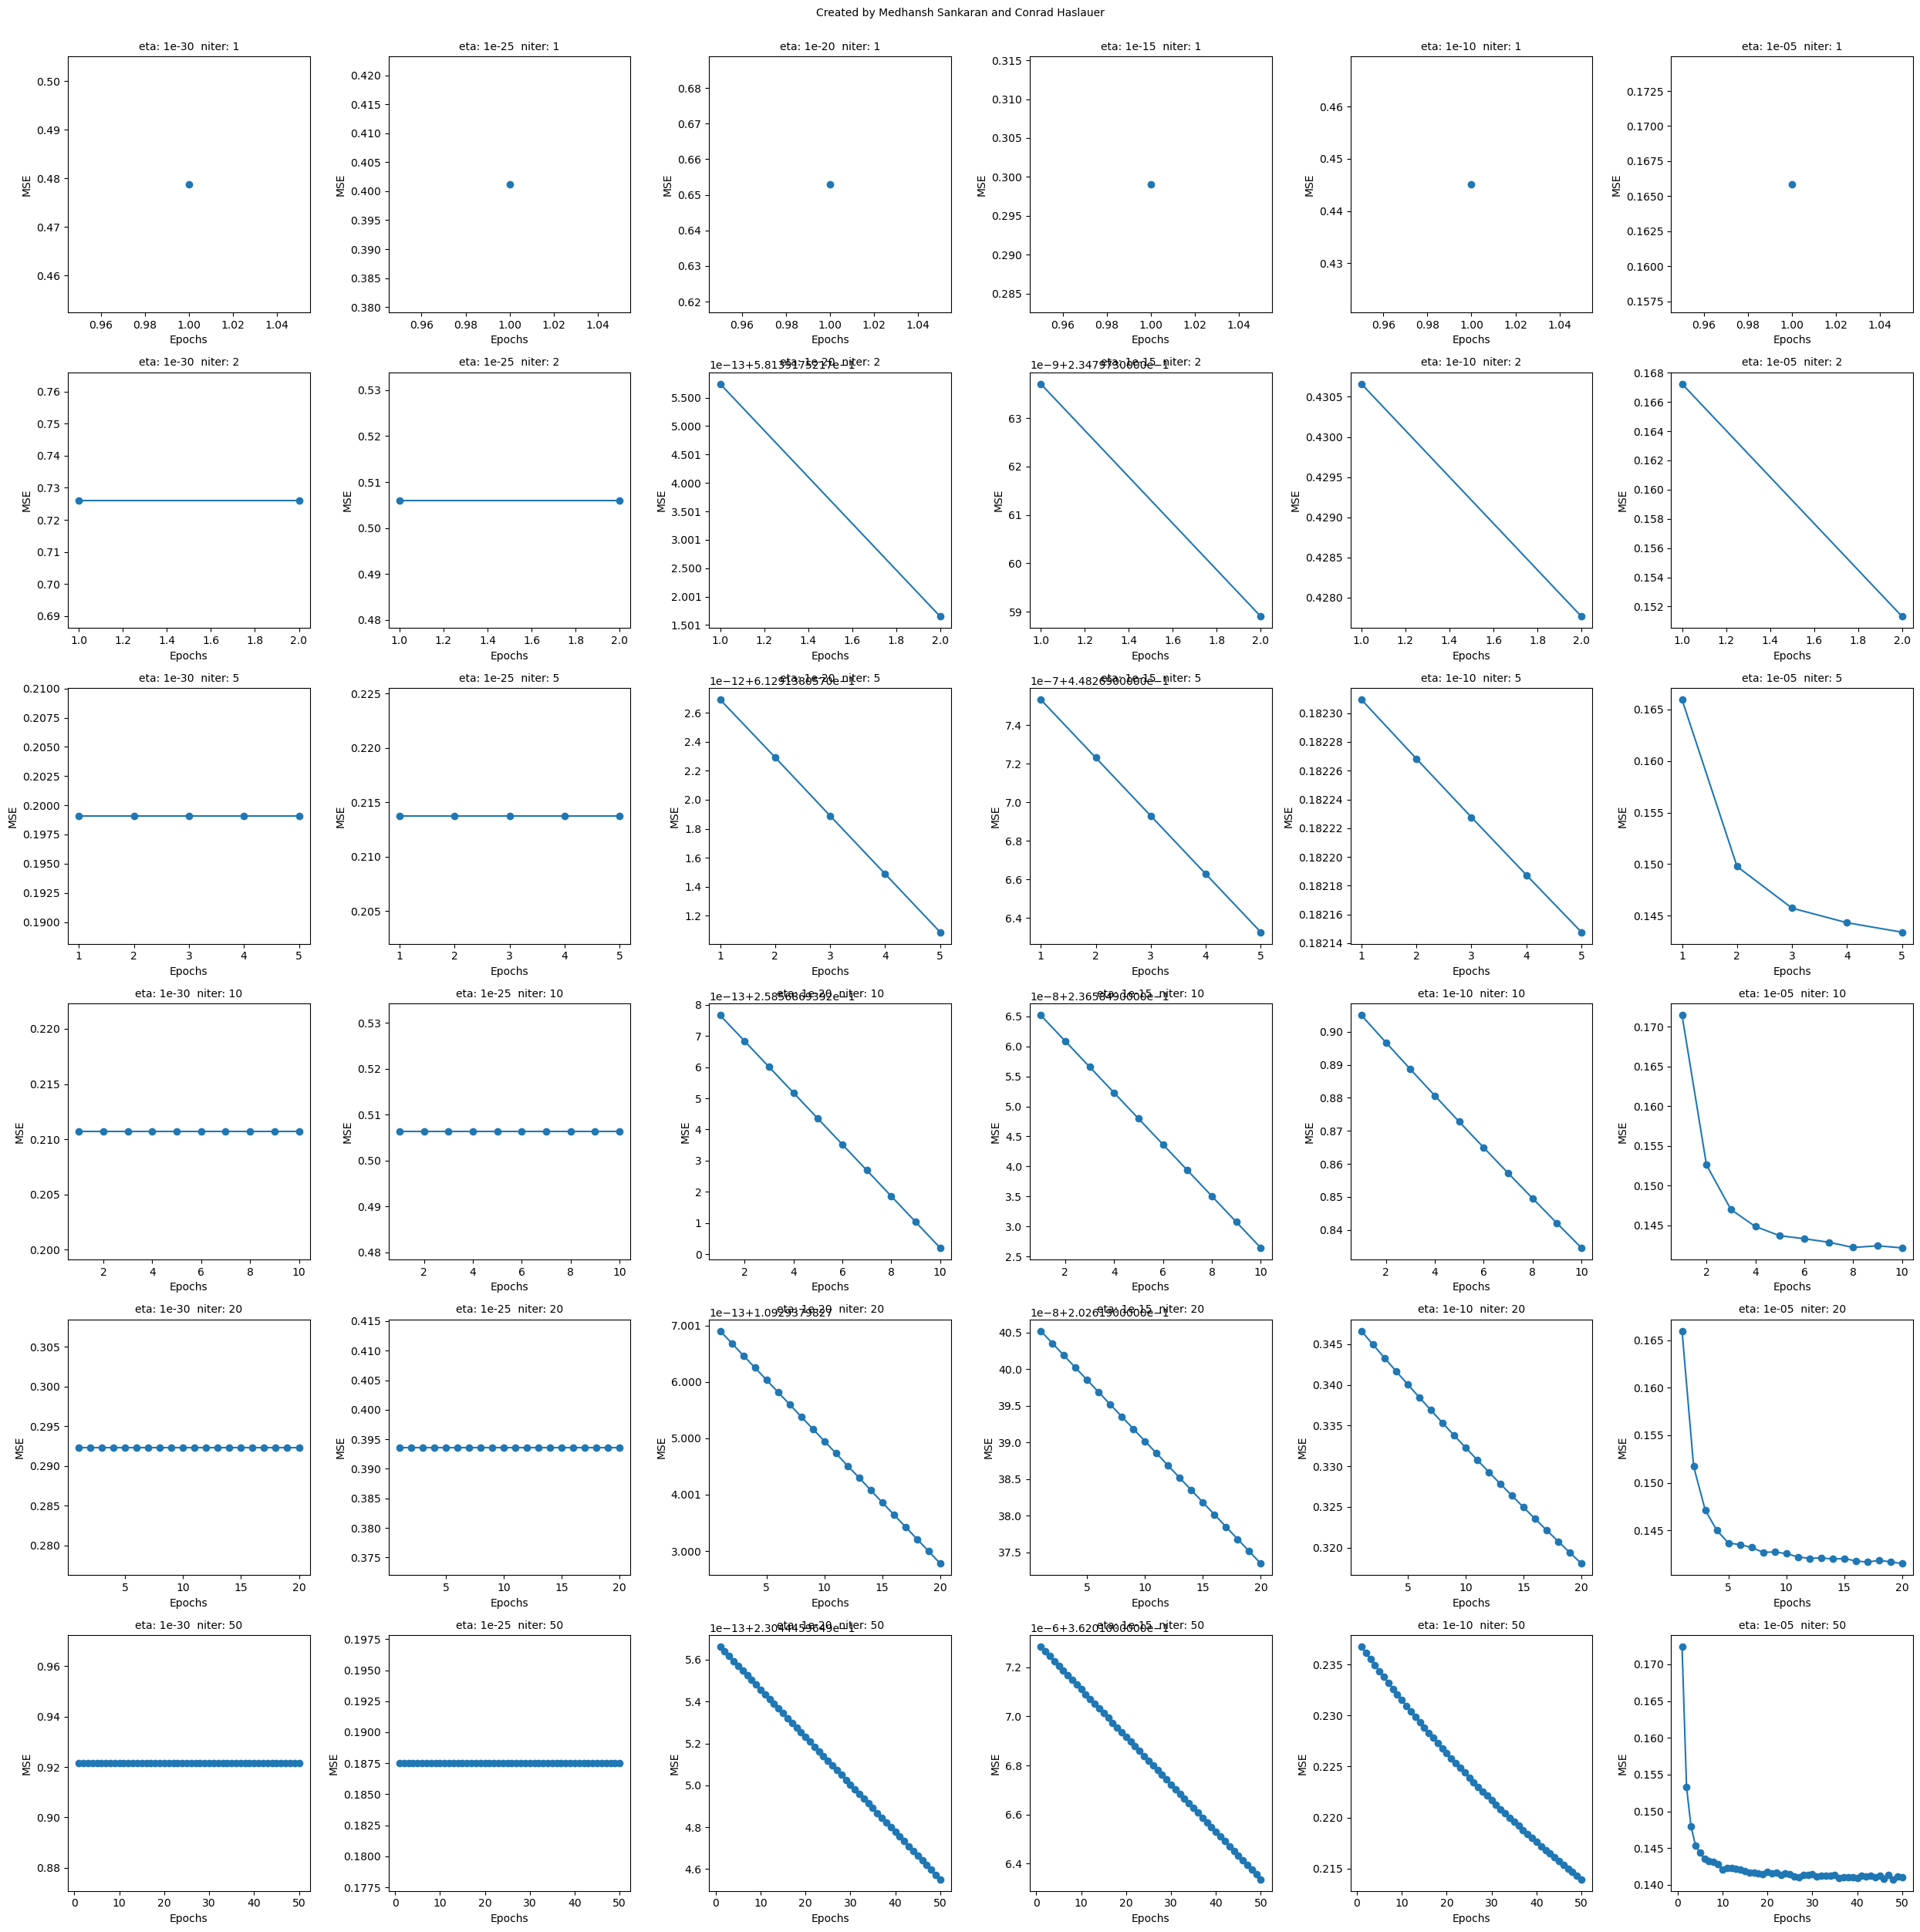

In [12]:
# Train Adaline and find good value of eta and n_iter
fig, ax = plt.subplots(nrows=6, ncols=6, figsize=(25, 25))

list_eta = [1e-30, 1e-25, 1e-20, 1e-15, 1e-10, 1e-5]
list_niter = [1, 2, 5, 10, 20, 50]

fig.suptitle("Created by Medhansh Sankaran and Conrad Haslauer", fontsize=10, y=1)

best_adsgda_acc = -1.0
best_adasgd_model = None
best_adasgd_params = (None, None)

for j, n_temp in enumerate(list_niter):

    for i, e_temp in enumerate(list_eta):
        ada = AdalineSGD(eta=e_temp, n_iter=n_temp).fit(X_train, y_train)

        y_pred = ada.predict(X_test)
        acc = accuracy_score(y_test, y_pred)

        ax[j, i].plot(range(1, len(ada.losses_) + 1), ada.losses_, marker='o')
        ax[j, i].set_xlabel('Epochs', fontsize=10)
        ax[j, i].set_ylabel('MSE', fontsize=10)
        ax[j, i].set_title(f"eta: {e_temp}  niter: {n_temp}", fontsize=10)

        if acc > best_ada_acc:
            best_adasgd_acc = acc
            best_adasgd_params = (e_temp, n_temp)
            best_adasgd_model = ada
    
plt.tight_layout()
plt.show()

In [13]:
# Best adaline model results
print(f"Best AdalineSGD Model - eta: {best_adasgd_params[0]}, n_iter: {best_adasgd_params[1]}, Accuracy: {best_adasgd_acc:.4f}")

Best AdalineSGD Model - eta: 1e-05, n_iter: 50, Accuracy: 0.7972


In [14]:
# As AdalineSGD performed better than GD, we will use Adaline SGD as the main Adaline Model

best_ada_model = best_adasgd_model

In [15]:
# Get project_validation_inputs.csv

df_valid = pd.read_csv('Data/project_validation_inputs.csv', encoding='utf-8')

# Preprocess validation data
X_valid, y_valid = preprocess_data(df_valid)

X_valid

array([[-8.75990753e-01,  2.00000000e+00, -2.76068828e-01, ...,
        -2.12958646e-01, -2.69811919e-01,  3.60000000e+01],
       [ 5.01758836e-01,  5.00000000e+00, -1.30219507e+00, ...,
        -2.12958646e-01, -1.03242517e-01,  3.60000000e+01],
       [-7.22907465e-01,  2.00000000e+00, -3.51967613e-02, ...,
        -2.12958646e-01,  1.14602800e+00,  3.60000000e+01],
       ...,
       [ 6.54842124e-01,  2.00000000e+00,  1.53978639e+00, ...,
        -2.12958646e-01,  5.63035090e-01,  3.60000000e+01],
       [-8.75990753e-01,  2.00000000e+00, -1.36693002e+00, ...,
        -2.12958646e-01, -1.03242517e-01,  3.60000000e+01],
       [-1.56486555e+00,  2.00000000e+00, -1.53370561e+00, ...,
        -2.12958646e-01, -1.35251303e+00,  3.60000000e+01]])

In [16]:
y_valid

In [17]:
ppn_valid_pred = best_model.predict(X_valid)
ada_valid_pred = best_ada_model.predict(X_valid)

In [18]:
# ppn_valid_pred

# ppn_preds = pd.DataFrame(ppn_valid_pred, columns=['Predicted_Income'])
# ppn_preds.to_csv('Data/validation_predictions/Group_8_Perceptron_PredictedOutputs.csv', index=False)

In [19]:
# ada_valid_pred

# ada_preds = pd.DataFrame(ada_valid_pred, columns=['Predicted_Income'])
# ada_preds.to_csv('Data/validation_predictions/Group_8_Adaline_PredictedOutputs.csv', index=False)

## Scikit-Learn

In [20]:
# scikit-learn pereptron and adaline implementations
from sklearn.linear_model import Perceptron as SklearnPerceptron
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

# Assumption:  This code assumes you have already clean, processed, and split a data set.
'''
Input Data Required:
X_train = cleaned, processed input data for training prediction models
y_train = response variable associated with X_train; truth values
X_test = cleaned, processed input data for testing prediction model created on training dataset
y_test = response variable associated with X_test; truth values

Note: Current order of rows ensure y_train = X_train and y_test = X_test, but if you sort and remove rows this association changes.
'''
# Scikit-learn Perceptron
sk_ppn = SklearnPerceptron(eta0=0.1, max_iter=15, random_state=42)
sk_ppn.fit(X_train, y_train)
sk_y_pred_ppn = sk_ppn.predict(X_test)
print(f"Scikit-learn Perceptron accuracy: {accuracy_score(y_test, sk_y_pred_ppn):.4f}")

# Scikit-learn Adaline (using SGDClassifier with 'log_loss' is closer, but 'perceptron' is available)
# For Adaline (which uses GD), SGDClassifier with 'hinge' loss is a good proxy, as it's a linear classifier with regularization
sk_ada = SGDClassifier(loss='perceptron', eta0=0.0001, learning_rate='constant', max_iter=15, random_state=42)
sk_ada.fit(X_train, y_train)
sk_y_pred_ada = sk_ada.predict(X_test)
print(f"Scikit-learn Adaline (SGDClassifier) accuracy: {accuracy_score(y_test, sk_y_pred_ada):.4f}")

Scikit-learn Perceptron accuracy: 0.7924
Scikit-learn Adaline (SGDClassifier) accuracy: 0.8231


In [21]:
# Implementing on the validation results
sk_ppn.fit(X_train, y_train)
valid_sk_ppn_pred = sk_ppn.predict(X_valid)
sk_ada.fit(X_train, y_train)
valid_sk_ada_pred = sk_ada.predict(X_valid)

sk_ppn_preds = pd.DataFrame(valid_sk_ppn_pred, columns=['Predicted_Income'])
sk_ppn_preds.to_csv('Data/validation_predictions/Group_8_Perceptron_PredictedOutputs.csv', index=False)
sk_ada_preds = pd.DataFrame(valid_sk_ada_pred, columns=['Predicted_Income'])
sk_ada_preds.to_csv('Data/validation_predictions/Group_8_Adaline_PredictedOutputs.csv', index=False)